#  Dataset Exploration

### Imports and Path Setup

In [9]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Dataset paths
train_img_dir = "/kaggle/input/d-fire/train/images"
train_label_dir = "/kaggle/input/d-fire/train/labels"
test_img_dir = "/kaggle/input/d-fire/test/images"
test_label_dir = "/kaggle/input/d-fire/test/labels"

### Statistics Calculation Functions

In [15]:
def get_dataset_stats(img_dir, label_dir):
    # Count files
    num_images = len(os.listdir(img_dir))
    num_labels = len(os.listdir(label_dir))
    
    # Check image dimensions
    img_shapes = []
    for img_file in os.listdir(img_dir)[:100]:  # sample first 100
        img = cv2.imread(os.path.join(img_dir, img_file))
        if img is not None:
            img_shapes.append(img.shape)
    
    # Check class distribution
    class_counts = Counter()
    for label_file in os.listdir(label_dir)[:100]:
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
    
    return {
        "num_images": num_images,
        "num_labels": num_labels,
        "image_shapes": img_shapes,
        "class_distribution": class_counts
    }

# Calculate statistics
print("Analyzing Dataset...\n")
train_stats = get_dataset_stats(train_img_dir, train_label_dir)
test_stats = get_dataset_stats(test_img_dir, test_label_dir)


def print_stats(title, stats):
    print(f"\n{'='*50}")
    print(f"{title.upper()} SET STATISTICS")
    print(f"{'='*50}")
    print(f"Total Images: {stats['num_images']:,}")
    print(f"Total Labels: {stats['num_labels']:,}")
    
    # Class distribution
    print("\nCLASS DISTRIBUTION (sample of 100 labels):")
    for class_id, count in stats['class_distribution'].items():
        print(f"Class {class_id} ({'fire' if class_id == 0 else 'smoke'}): {count} instances")
    
    # Image dimensions analysis
    shapes = np.array(stats['image_shapes'])
    print("\nIMAGE DIMENSIONS ANALYSIS (sample of 100 images):")
    print(f"Average (H,W): ({shapes[:,0].mean():.0f}, {shapes[:,1].mean():.0f})")
    print(f"Minimum (H,W): ({shapes[:,0].min()}, {shapes[:,1].min()})")
    print(f"Maximum (H,W): ({shapes[:,0].max()}, {shapes[:,1].max()})")
    print(f"Most common size: {Counter([(h,w) for h,w,_ in shapes]).most_common(1)[0][0]}")


# Display statistics
print_stats("Train", train_stats)
print_stats("Test", test_stats)

Analyzing Dataset...


TRAIN SET STATISTICS
Total Images: 17,221
Total Labels: 17,221

CLASS DISTRIBUTION (sample of 100 labels):
Class 0 (fire): 62 instances
Class 1 (smoke): 74 instances

IMAGE DIMENSIONS ANALYSIS (sample of 100 images):
Average (H,W): (563, 971)
Minimum (H,W): (240, 202)
Maximum (H,W): (768, 1499)
Most common size: (720, 1280)

TEST SET STATISTICS
Total Images: 4,306
Total Labels: 4,306

CLASS DISTRIBUTION (sample of 100 labels):
Class 0 (fire): 54 instances
Class 1 (smoke): 82 instances

IMAGE DIMENSIONS ANALYSIS (sample of 100 images):
Average (H,W): (590, 1006)
Minimum (H,W): (167, 302)
Maximum (H,W): (1024, 1868)
Most common size: (720, 1280)


# Visualization of sample images of the dataset

Total Training Images: 17221


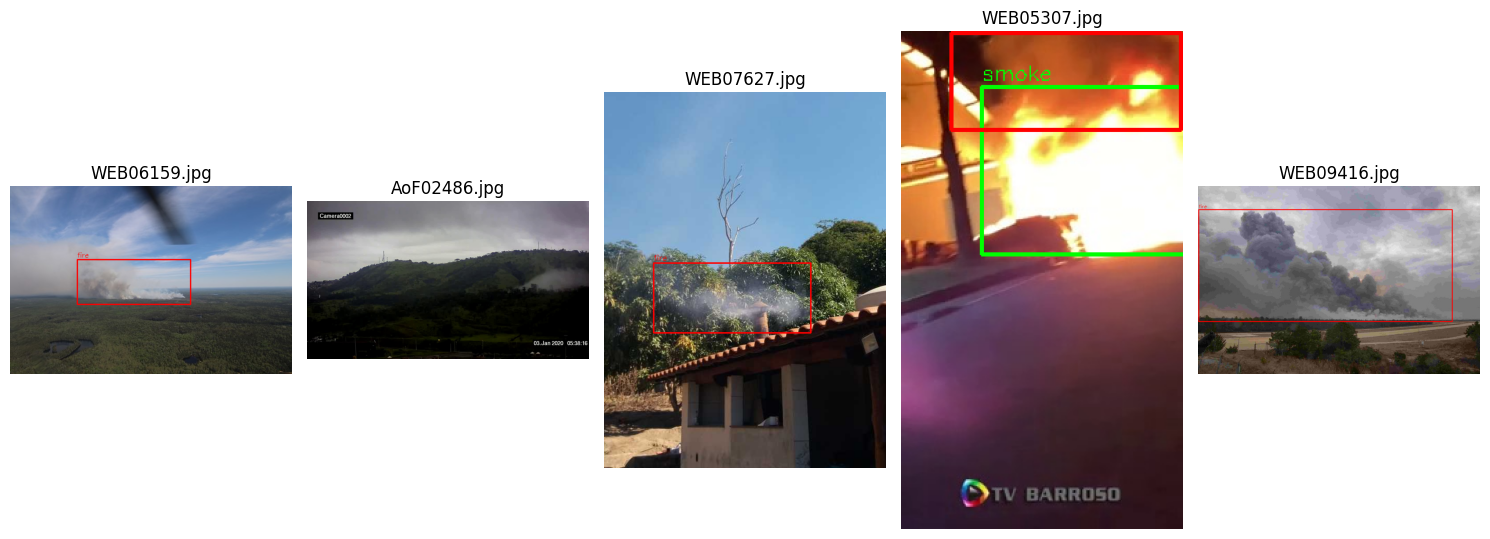

Total Testing Images: 4306


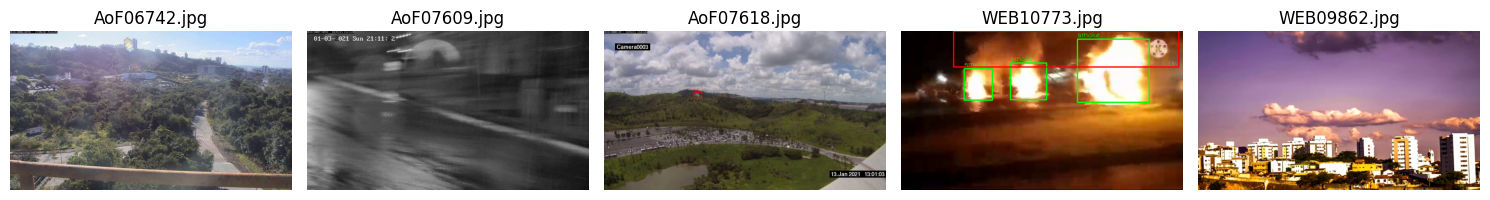

In [24]:
def plot_samples(img_dir, label_dir, num_samples=5, dataset_name="Dataset"):
    # Get the total number of images
    total_images = len(os.listdir(img_dir))
    
    # Print the total number of images
    print(f"Total {dataset_name} Images: {total_images}")
    
    plt.figure(figsize=(15, 10))
    sample_files = random.sample(os.listdir(img_dir), num_samples)
    
    for i, img_file in enumerate(sample_files):
        # Load image
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load corresponding label
        label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        boxes = []
        classes = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, box_w, box_h = map(float, parts[1:5])
                    
                    # Convert from YOLO format to pixel coordinates
                    x1 = int((x_center - box_w/2) * w)
                    y1 = int((y_center - box_h/2) * h)
                    x2 = int((x_center + box_w/2) * w)
                    y2 = int((y_center + box_h/2) * h)
                    
                    boxes.append([x1, y1, x2, y2])
                    classes.append(class_id)
        
        # Draw bounding boxes
        for box, cls_id in zip(boxes, classes):
            color = (255, 0, 0) if cls_id == 0 else (0, 255, 0)  # assuming 0=fire, 1=smoke
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(img, f"{'fire' if cls_id == 0 else 'smoke'}", (box[0], box[1]-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_file))
    
    plt.tight_layout()
    plt.show()

# Print and plot for training set
plot_samples(train_img_dir, train_label_dir, num_samples=5, dataset_name="Training")

# Print and plot for test set
plot_samples(test_img_dir, test_label_dir, num_samples=5, dataset_name="Testing")


### Visualization of class distribution

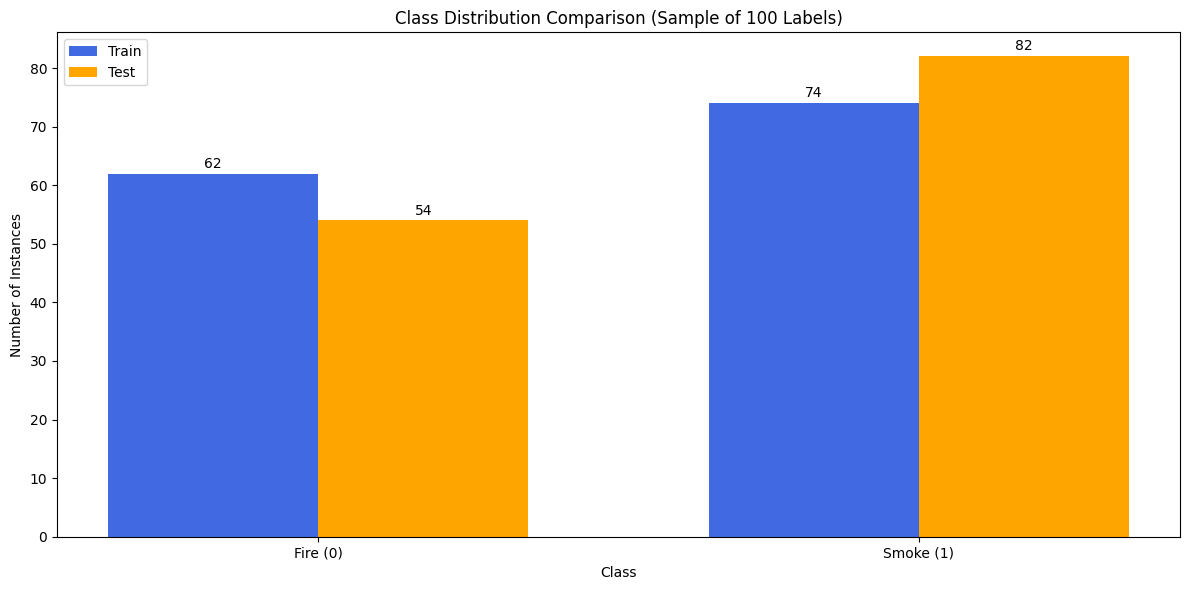

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train_stats, test_stats):
    plt.figure(figsize=(12, 6))
    
    # Prepare data
    train_counts = train_stats['class_distribution']
    test_counts = test_stats['class_distribution']
    
    classes = ['Fire (0)', 'Smoke (1)']
    train_values = [train_counts[0], train_counts[1]]
    test_values = [test_counts[0], test_counts[1]]
    
    x = np.arange(len(classes))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, train_values, width, label='Train', color='royalblue')
    plt.bar(x + width/2, test_values, width, label='Test', color='orange')
    
    # Add details
    plt.title('Class Distribution Comparison (Sample of 100 Labels)')
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.xticks(x, classes)
    plt.legend()
    
    # Add value labels
    for i, (train_val, test_val) in enumerate(zip(train_values, test_values)):
        plt.text(i - width/2, train_val + 1, str(train_val), ha='center')
        plt.text(i + width/2, test_val + 1, str(test_val), ha='center')
    
    plt.tight_layout()
    plt.show()

# Plot class distribution
plot_class_distribution(train_stats, test_stats)

### visualization of Size Distribution 

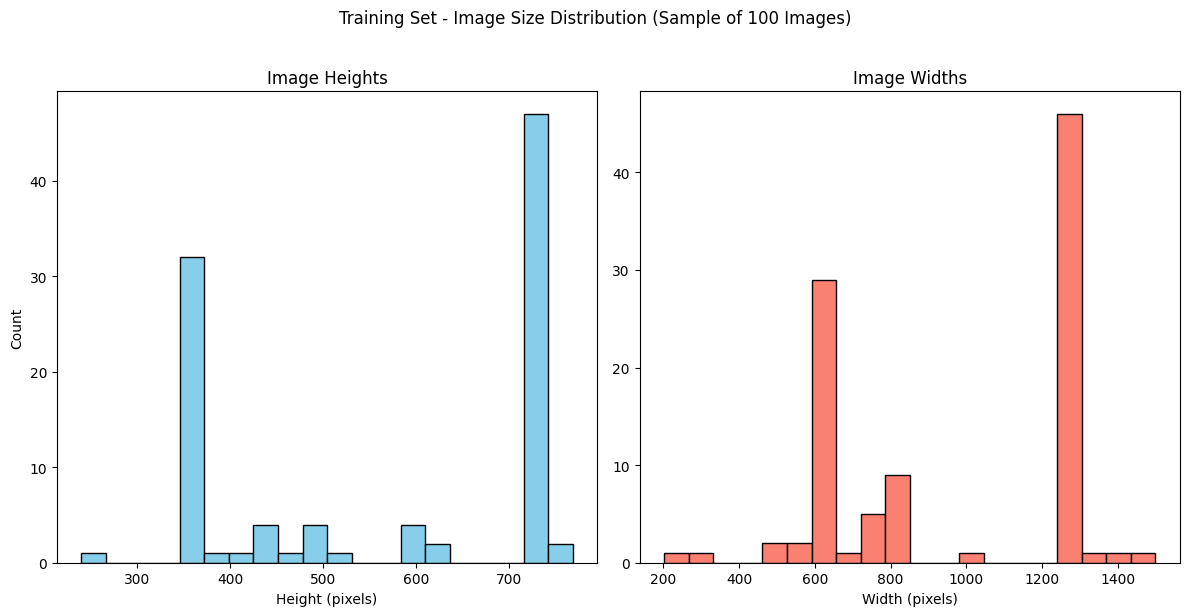

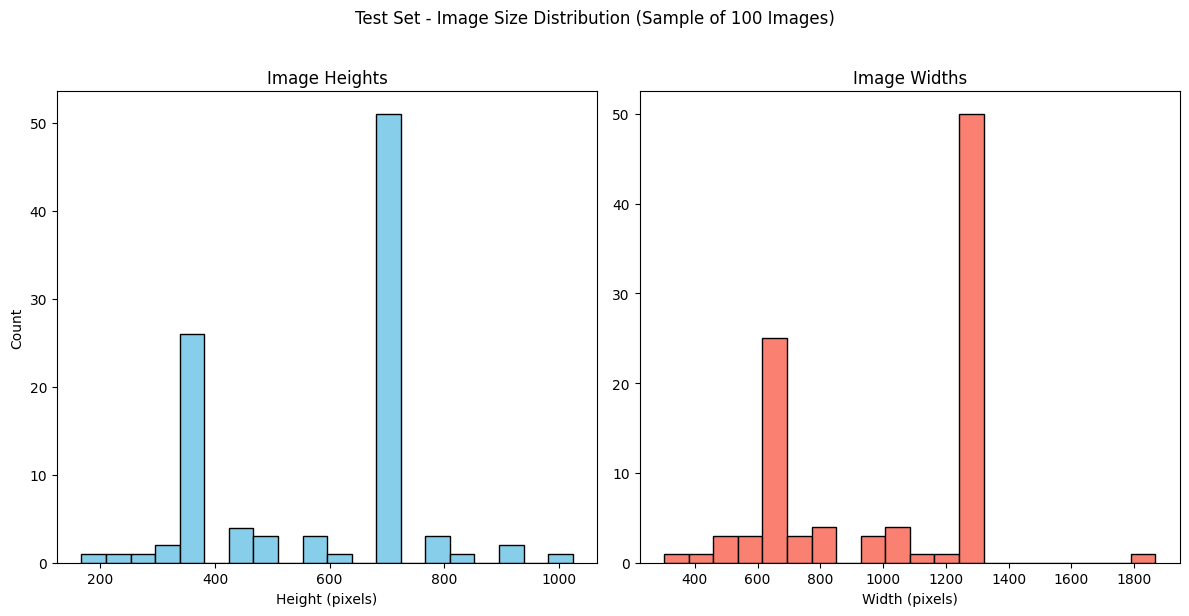

In [29]:
def plot_size_distribution(stats, title):
    shapes = np.array(stats['image_shapes'])
    heights = shapes[:, 0]
    widths = shapes[:, 1]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{title} - Image Size Distribution (Sample of 100 Images)', y=1.02)
    
    # Height distribution
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Count')
    plt.title('Image Heights')
    
    # Width distribution
    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='salmon', edgecolor='black')
    plt.xlabel('Width (pixels)')
    plt.title('Image Widths')
    
    plt.tight_layout()
    plt.show()

# Plot size distributions for training and test sets
plot_size_distribution(train_stats, "Training Set")
plot_size_distribution(test_stats, "Test Set")


###  Training and Testing class distribution pie charts

Total Training Images: 17221
Total Testing Images: 4306


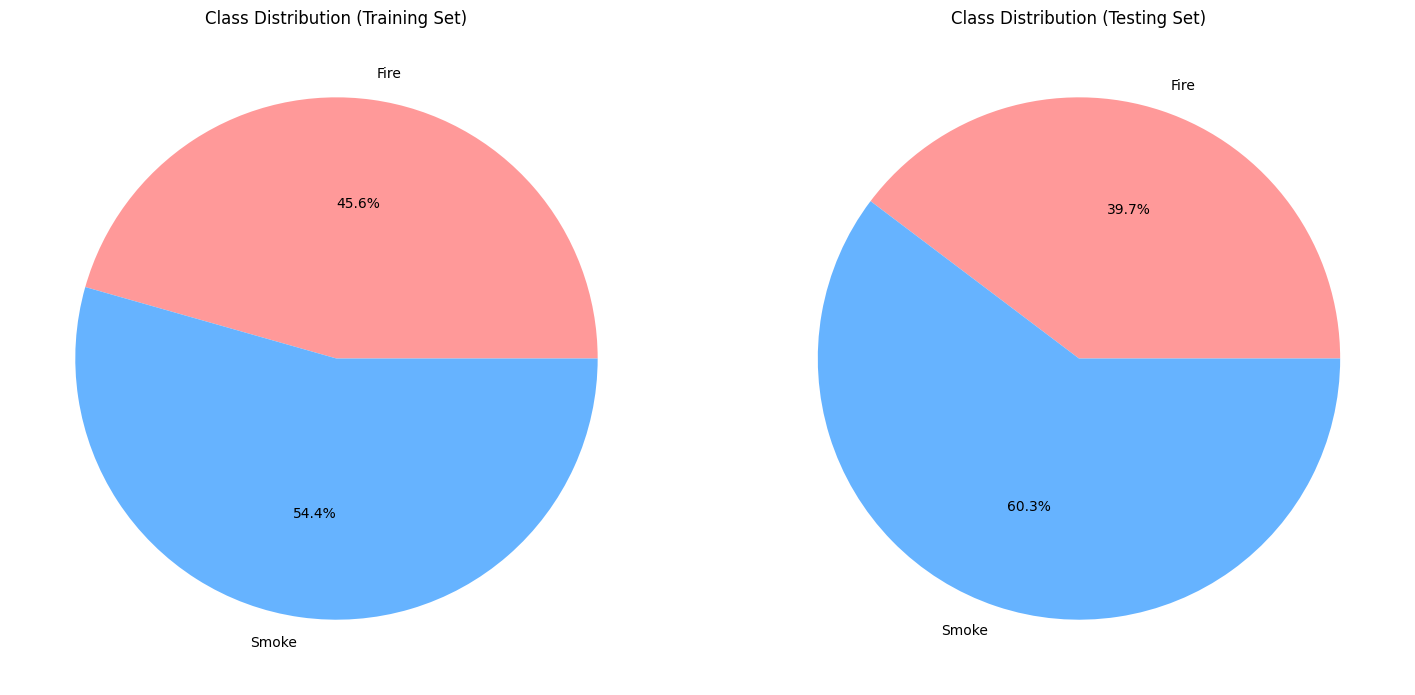

In [37]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Dataset paths
train_img_dir = "/kaggle/input/d-fire/train/images"
train_label_dir = "/kaggle/input/d-fire/train/labels"
test_img_dir = "/kaggle/input/d-fire/test/images"
test_label_dir = "/kaggle/input/d-fire/test/labels"

def plot_class_distribution_side_by_side(train_img_dir, train_label_dir, test_img_dir, test_label_dir):
    # Total images in Training and Testing sets
    total_train_images = len(os.listdir(train_img_dir))
    total_test_images = len(os.listdir(test_img_dir))
    
    # Print total images
    print(f"Total Training Images: {total_train_images}")
    print(f"Total Testing Images: {total_test_images}")
    
    # Class distribution for training set
    train_class_counts = Counter()
    for label_file in os.listdir(train_label_dir)[:100]:  # sample first 100 labels
        with open(os.path.join(train_label_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                train_class_counts[class_id] += 1

    # Class distribution for testing set
    test_class_counts = Counter()
    for label_file in os.listdir(test_label_dir)[:100]:  # sample first 100 labels
        with open(os.path.join(test_label_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                test_class_counts[class_id] += 1

    # Plotting side by side
    plt.figure(figsize=(15, 7))

    # Training set pie chart
    plt.subplot(1, 2, 1)
    plt.pie(train_class_counts.values(), labels=['Fire', 'Smoke'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title('Class Distribution (Training Set)')

    # Testing set pie chart
    plt.subplot(1, 2, 2)
    plt.pie(test_class_counts.values(), labels=['Fire', 'Smoke'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title('Class Distribution (Testing Set)')

    plt.tight_layout()
    plt.show()

# Plot class distribution side by side
plot_class_distribution_side_by_side(train_img_dir, train_label_dir, test_img_dir, test_label_dir)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


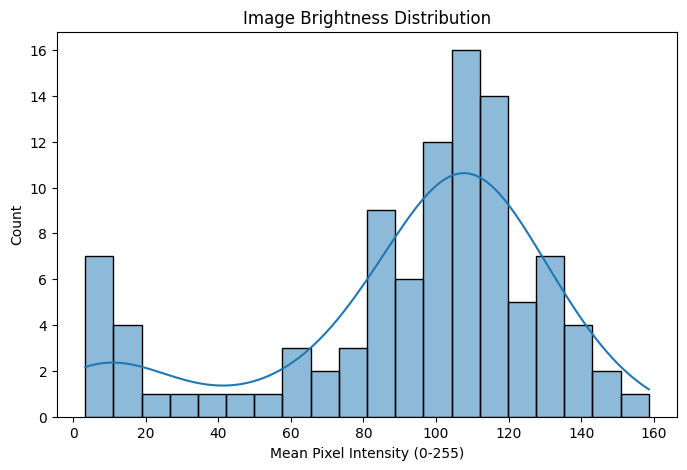

In [8]:
# For more advanced analysis:
def advanced_analysis(img_dir, label_dir):
    # 9. Image Brightness Analysis
    brightness = []
    for img_file in os.listdir(img_dir)[:100]:
        img = cv2.imread(os.path.join(img_dir, img_file))
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            brightness.append(gray.mean())
    
    plt.figure(figsize=(8, 5))
    sns.histplot(brightness, bins=20, kde=True)
    plt.title('Image Brightness Distribution')
    plt.xlabel('Mean Pixel Intensity (0-255)')
    plt.show()

advanced_analysis(train_img_dir, train_label_dir)

# model implementation

In [39]:
pip install ultralytics

  Using cached ultralytics-8.3.113-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached ultralytics-8.3.113-py3-none-any.whl (982 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.7

In [ ]:
from ultralytics import YOLO

# Initialize the YOLO model
model = YOLO("yolov8n.yaml")  # You can start with a small YOLOv8 model like yolov8n (nano version)

# Train the model
model.train(data='/kaggle/input/annoatation-file/data.yaml', epochs=20, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/input/annoatation-file/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.4 ms, read: 17.5±11.9 MB/s, size: 94.3 KB)


train: Scanning /kaggle/input/d-fire/train/labels... 17195 images, 7832 backgrounds, 26 corrupt: 100%|██████████| 17221/17221 [00:57<00:00, 300.87it/s]

train: /kaggle/input/d-fire/train/images/WEB02521.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB02521.jpg'
train: /kaggle/input/d-fire/train/images/WEB06626.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB06626.jpg'
train: /kaggle/input/d-fire/train/images/WEB07199.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07199.jpg'
train: /kaggle/input/d-fire/train/images/WEB07271.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07271.jpg'
train: /kaggle/input/d-fire/train/images/WEB07278.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07278.jpg'
train: /kaggle/input/d-fire/train/images/WEB07297.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB072

WARNING ⚠️ train: Cache directory /kaggle/input/d-fire/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 69.3±77.1 MB/s, size: 55.9 KB)


val: Scanning /kaggle/input/d-fire/train/labels... 17195 images, 7832 backgrounds, 26 corrupt: 100%|██████████| 17221/17221 [00:15<00:00, 1082.63it/s]

val: /kaggle/input/d-fire/train/images/WEB02521.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB02521.jpg'
val: /kaggle/input/d-fire/train/images/WEB06626.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB06626.jpg'
val: /kaggle/input/d-fire/train/images/WEB07199.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07199.jpg'
val: /kaggle/input/d-fire/train/images/WEB07271.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07271.jpg'
val: /kaggle/input/d-fire/train/images/WEB07278.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07278.jpg'
val: /kaggle/input/d-fire/train/images/WEB07297.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/d-fire/train/images/WEB07297.jpg'
val:

WARNING ⚠️ val: Cache directory /kaggle/input/d-fire/train is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.17G      2.847      3.719      3.166         28        640: 100%|██████████| 1075/1075 [03:27<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 538/538 [01:16<00:00,  7.04it/s]


                   all      17195      21320      0.196      0.224       0.12     0.0408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G      2.125      2.513      2.195         19        640: 100%|██████████| 1075/1075 [03:20<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 538/538 [01:13<00:00,  7.27it/s]


                   all      17195      21320      0.321      0.307      0.243      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      1.952      2.253      1.981         17        640: 100%|██████████| 1075/1075 [03:17<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 538/538 [01:13<00:00,  7.34it/s]


                   all      17195      21320       0.42      0.364      0.318      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         3G      1.881      2.151        1.9         41        640:  13%|█▎        | 141/1075 [00:26<03:12,  4.85it/s]